In [1]:
from helpers import *

In [2]:
%matplotlib inline

### Run some samples with interpolation in the middle

In [3]:
def curve_score(curve):
    if (np.mean(curve[:4]) - np.mean(curve[9:15])) < 0:
        return 1.
    #if (np.mean(curve[:4]) - np.mean(curve[9:15]))
    ft = scipy.fft(curve)
    return (np.linalg.norm(ft[3:-2])/np.linalg.norm(ft[1:]))**2

def piecewise_linear(num_slices, slice_num):
    '''Return interpolation multipliers for slice thickness assuming a piecewise linear model for the LV'''
    x = np.linspace(-1, num_slices+1)
    y = np.ones_like(x)
    y[27:] = np.linspace(1, 0.5, 23)
    return y[50*slice_num/num_slices]

def piecewise_interp(curves):
    # Get good curves and their locations
    good = {i:c for i,c in enumerate(curves) if curve_score(c) < 0.1}
    locs = good.keys()
    if len(locs) == 0:
        print 'Interpolation failed, no good curves available'
        return curves
    #Last element is the apex
    area_multipliers = [piecewise_linear(len(curves), i)**2 for i in range(len(curves))] 
    #Determine if orientation is reversed
    if max(good[max(locs)]) > max(good[min(locs)]): 
        #In this case, index 0 is apex 
        area_multipliers = area_multipliers[::-1]
    #### Extrapolate everything to the left of min
    for i in range(min(locs)-1, -1, -1):
        #print 'Correcting %d with multiplier %f' % (i, area_multipliers[i]/area_multipliers[i+1])
        curves[i] = curves[i+1]*(area_multipliers[i]/area_multipliers[i+1])
    #### Extrapolate everything to the right of max
    for i in range(max(locs)+1, len(curves)):
        #print 'Correcting %d with multiplier %f' % (i, area_multipliers[i]/area_multipliers[i-1])
        curves[i] = curves[i-1]*(area_multipliers[i]/area_multipliers[i-1])
    ### Interpolate everything in the middle
    for i in range(min(locs)+1, max(locs)):
        if i not in locs:
            #print 'Correcting %d with multiplier %f' % (i, area_multipliers[i]/area_multipliers[i-1])
            curves[i] = curves[i-1]*(area_multipliers[i]/area_multipliers[i-1])
    return curves 

In [6]:
def run_pipeline(case):
    patient, meta = all_slices(case, pix=True)
    # get layer meta data
    pix_spacing = np.array([m['PixelSpacing'] for m in meta])
    heights = get_heights_from_meta(meta)
    # get middle
    num_layers, num_times = np.shape(patient)[0:2]
    mid_layer = num_layers//2
    ############### start get region of interest ##################
    for iteration in range(BBOX_ITERS):
        mid_slice = patient[mid_layer]
        mid_slice_stfd = spatial_temporal_finite_difference(mid_slice)
        mid_slice_stfd = threshold_std(mid_slice_stfd)
        # blur
        result = ndimage.gaussian_filter(mid_slice_stfd, GAUSSIAN_BLUR_PRE_CENTROID_STFD)
        # get centroid
        row,col = get_centroid(result)
        # get roi
        rstart, rend, cstart, cend = bounding_square(result, row, col)
        # crop patient
        patient = map(lambda sl: map(lambda x: x[rstart:rend, cstart:cend], sl), patient)
    ############### end get region of interest ##################
    ## GET EXPECTED SIZE AS PROP OF ROI ##
    max_size_pix = 1000.*MAX_ML/(heights.min()*pix_spacing.min())
    roi_size_pix = ((rend-rstart)*(cend-cstart))
    lv_fraction = 1.*max_size_pix/roi_size_pix
    frac_to_remove = max(.7, min(.8, 1.-lv_fraction))*100
    ## END GET EXPECTED SIZE AS PROP OF ROI ##
    ############### start prop through space and time ##################
    # initialize tracks array
    shape = np.shape(patient)
    tracks = np.zeros(shape)
    priors = np.zeros(shape)
    posts = np.zeros(shape)
    masks = np.zeros(shape)
    # compute mid_layer prior and prop through time
    mid_layer_stfd = spatial_temporal_finite_difference(patient[mid_layer])
    prior = ndimage.gaussian_filter(mid_layer_stfd, GAUSSIAN_BLUR_PRE_CENTROID_STFD**2) #TODO: update this

    masks[mid_layer] = get_slice_components(patient[mid_layer], perc=frac_to_remove)
    priors[mid_layer], posts[mid_layer], tracks[mid_layer] = \
        zip(*prop_through_time(masks[mid_layer], prior=prior, end_t=num_times))
    # prop down
    for curr in range(mid_layer+1,num_layers):
        prev = curr - 1
        prior = calculate_layer_prior(tracks, prev=prev)
        masks[curr] = get_slice_components(patient[curr], perc=frac_to_remove)
        priors[curr], posts[curr], tracks[curr] = \
            zip(*prop_through_time(masks[curr], prior=prior, end_t=num_times))
    # prop up
    for curr in range(mid_layer)[::-1]: # mid_layer-1, mid_layer-2
        prev = curr + 1
        prior = calculate_layer_prior(tracks, prev=prev)
        masks[curr] = get_slice_components(patient[curr], perc=frac_to_remove)
        priors[curr], posts[curr], tracks[curr] = \
            zip(*prop_through_time(masks[curr], prior=prior, end_t=num_times))
    ############### end prop through space and time ##################
        # sum over pixels (still have (num_layers, num_times) array)
    a = tracks.sum(2).sum(2)
    num_times = tracks.shape[1]
    a_interp = linear_interpolate(a, num_times)
    #a_interp = piecewise_interp(a_interp)
    # multiply each layer by its pixel size to get mm^2
    areas = pix_spacing[:,None] * a_interp
    # multiply each area by its height to get mm^3
    volumes = heights[:,None] * areas
    # return the sum of volumes over layers in ml
    #volume = np.sum(volumes, 0)/1000.
    return volumes#min(volume), max(volume)

### Run Pipeline on Patients with Interpolation

In [100]:
results = {}
broken = []
for i in range(1,501):
    if i%20 == 0:
        print 'Done with...', i
    try:
        results[i] = run_pipeline(i)
    except:
        broken.append(i)

Interpolation failed, no good curves available
Interpolation failed, no good curves available
Done with... 20
Done with... 40
Interpolation failed, no good curves available
Interpolation failed, no good curves available
Done with... 60
Interpolation failed, no good curves available
Interpolation failed, no good curves available
Done with... 80
Done with... 100
Done with... 120
Using min length 30.
Interpolation failed, no good curves available
Interpolation failed, no good curves available
Interpolation failed, no good curves available
Done with... 140
Interpolation failed, no good curves available
Interpolation failed, no good curves available
Done with... 160
Interpolation failed, no good curves available
Done with... 180
Done with... 200
Interpolation failed, no good curves available
Done with... 220
Using min length 60.
Interpolation failed, no good curves available
Done with... 240
Interpolation failed, no good curves available
Done with... 260
Interpolation failed, no good curves

In [103]:
systole = []
diastole = []
for res in results:
    systole.append(results[res][0])
    diastole.append(results[res][1])

In [104]:
import pandas
train_labels = pandas.read_csv(root_train+'.csv')
train_labels['EF'] = (train_labels.Diastole - train_labels.Systole)/train_labels.Diastole
train_labels = train_labels.set_index(train_labels.Id)
train_labels = train_labels.drop([41,83,148,195,222,260,280,305,337,393,437,442,456])
train = np.array(train_labels)

In [102]:
len(broken)

13

In [105]:
train[:196,1:3].shape

(196, 2)

### With Interp

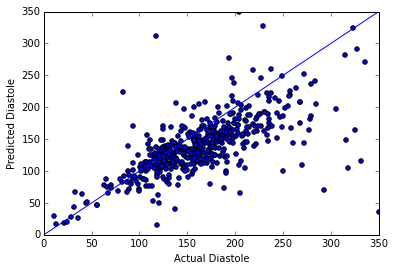

In [123]:
plt.scatter(train[:,2], diastole)
plt.xlim(0,350)
plt.ylim(0,350)
xs = np.linspace(0, 350)
ys = np.linspace(0, 350)
plt.xlabel("Actual Diastole")
plt.ylabel("Predicted Diastole")
plt.plot(xs, ys)

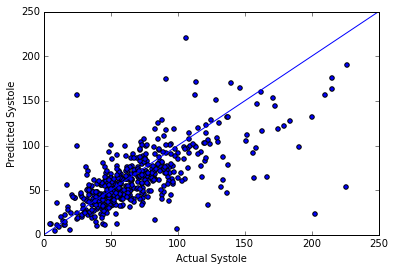

In [122]:
plt.scatter(train[:,1], systole)
plt.xlim(0,250)
plt.ylim(0,250)
xs = np.linspace(0, 250)
ys = np.linspace(0, 250)
plt.xlabel("Actual Systole")
plt.ylabel("Predicted Systole")
plt.plot(xs, ys)

In [115]:
diastole = np.array(diastole)
diastole[np.isnan(diastole)] = 100
dev = (train[:,2] - diastole)
dev.std()

45.682486898121539

In [117]:
systole = np.array(systole)
systole[np.isnan(systole)] = 100
dev = (train[:,1] - systole)
dev.std()

33.473623394137718

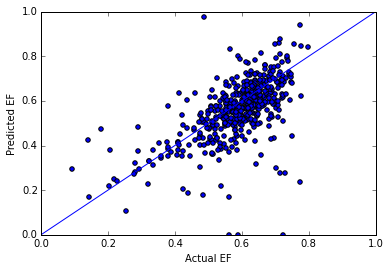

In [118]:
ef = (diastole - systole)/diastole
actual_ef = (train[:,2] - train[:,1])/train[:,2]
plt.scatter(actual_ef, ef)
plt.xlim(0,1)
plt.ylim(0,1)
xs = np.linspace(0, 1)
ys = np.linspace(0, 1)
plt.xlabel("Actual EF")
plt.ylabel("Predicted EF")
plt.plot(xs, ys)

In [119]:
ef = np.array(ef)
dev = (actual_ef - ef)
dev.std()

0.11106249199062658

In [234]:
def do_cdf(point,std):
    cdf = np.zeros((600,))
    std = int(std)
    point = int(point)
    cdf[point] = 1
    cdf = np.cumsum(ndimage.gaussian_filter1d(cdf,std))
    return cdf

### Diastole Scores

In [255]:
scores = []
broken = []
for i in range(len(diastole)):
    try:
        #cdf = np.zeros(600)
        #lb = int(max(diastole[i] - 0.4*diastole[i], 0))
        #ub = int(min(diastole[i] + 0.4*diastole[i], 600))
        #cdf[lb: ub] = np.linspace(0,1,(ub-lb)) 
        #cdf[ub:] = 1
        cdf = do_cdf(diastole[i], 35)
        scores.append(crps(cdf, int(train[i,2])))
    except:
        broken.append(i)
    #plt.plot(cdf)

In [256]:
scores = np.array(scores)
scores.mean()

0.043375423378002848

### Systole Scores

In [247]:
scores = []
broken = []
for i in range(len(systole)):
    try:
        #cdf = np.zeros(600)
        #lb = int(max(systole[i] - 0.4*systole[i], 0))
        #ub = int(min(systole[i] + 0.4*systole[i], 600))
        #cdf[lb: ub] = np.linspace(0,1,(ub-lb)) 
        #cdf[ub:] = 1
        cdf = do_cdf(systole[i], 25)
        scores.append(crps(cdf, int(train[i,1])))
    except:
        broken.append(i)
    #plt.plot(cdf)

In [248]:
scores = np.array(scores)
scores.mean()

0.025123697529437806

# Linear Regression to fix errors at diastole

('Coefficients: \n', array([[ 0.91957824]]))
Residual sum of squares: 1856.77
Variance score: 0.34


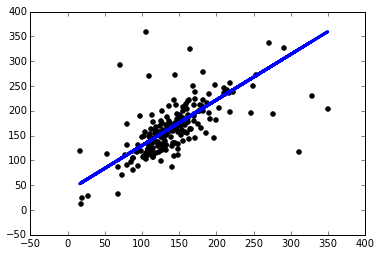

In [265]:
from sklearn import datasets, linear_model

# Split the data into training/testing sets
diastole_train = diastole[:-200].reshape((287,1))
diastole_test = diastole[-200:].reshape((200,1))
# Split the targets into training/testing sets
actual_diastole_train = train[:-200,2].reshape((287,1))
actual_diastole_test = train[-200:,2].reshape((200,1))
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(diastole_train, actual_diastole_train)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(diastole_test) - actual_diastole_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(diastole_test, actual_diastole_test))

# Plot outputs
plt.scatter(diastole_test, actual_diastole_test,  color='black')
plt.plot(diastole_test, regr.predict(diastole_test), color='blue',
         linewidth=3)

In [2]:
improved_diastole = regr.predict(diastole[-200:].reshape(200,1))
plt.scatter(train[-200:,2], improved_diastole)
plt.xlim(0,350)
plt.ylim(0,350)
xs = np.linspace(0, 350)
ys = np.linspace(0, 350)
plt.xlabel("Actual Diastole")
plt.ylabel("Predicted Diastole")
plt.plot(xs, ys)

NameError: name 'regr' is not defined

In [1]:
scores = []
broken = []
for i in range(len(improved_diastole)):
    try:
        cdf = do_cdf(improved_diastole[i], 35)
        scores.append(crps(cdf, int(train[i,2])))
    except:
        broken.append(i)
    #plt.plot(cdf)

NameError: name 'improved_diastole' is not defined

In [282]:
scores = np.array(scores)
scores.mean()

0.036792756143000267

## Linear Regression to fix errors at Systole

('Coefficients: \n', array([[ 0.97205693]]))
Residual sum of squares: 929.75
Variance score: 0.33


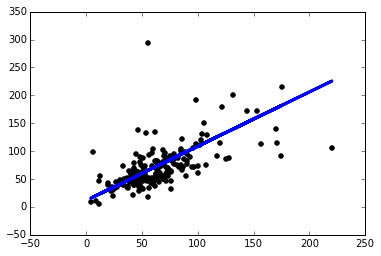

In [271]:
from sklearn import datasets, linear_model

# Split the data into training/testing sets
systole_train = systole[:-200].reshape((287,1))
systole_test = systole[-200:].reshape((200,1))
# Split the targets into training/testing sets
actual_systole_train = train[:-200,1].reshape((287,1))
actual_systole_test = train[-200:,1].reshape((200,1))
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(systole_train, actual_systole_train)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(systole_test) - actual_systole_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(systole_test, actual_systole_test))
# Plot outputs
plt.scatter(systole_test, actual_systole_test,  color='black')
plt.plot(systole_test, regr.predict(systole_test), color='blue',
         linewidth=3)

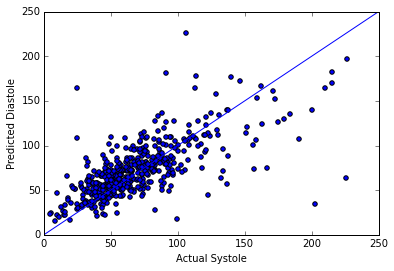

In [272]:
improved_systole = regr.predict(systole.reshape(487,1))
plt.scatter(train[:,1], improved_systole)
plt.xlim(0,250)
plt.ylim(0,250)
xs = np.linspace(0, 250)
ys = np.linspace(0, 250)
plt.xlabel("Actual Systole")
plt.ylabel("Predicted Diastole")
plt.plot(xs, ys)

In [286]:
scores = []
broken = []
for i in range(len(improved_systole)):
    try:
        cdf = do_cdf(improved_systole[i], 20)
        scores.append(crps(cdf, int(train[i,1])))
    except:
        broken.append(i)
scores = np.array(scores)
scores.mean()

0.024736714638404919

## Other Regression

In [257]:
import pandas
train_labels = pandas.read_csv(root_train+'.csv')
train_labels['EF'] = (train_labels.Diastole - train_labels.Systole)/train_labels.Diastole
train_labels = train_labels.set_index(train_labels.Id)
dat = train_labels.drop([41,83,148,195,222,260,280,305,337,393,437,442,456])

y = dat['Diastole'].as_matrix()
X = dat[['Estimate Dia', 'Estimate Sys', 'Age']]
sex = pandas.get_dummies(dat['Sex'])
X = X.join(sex)
# X = sm.add_constant(X, prepend=False)
model = sm.OLS(y[:75], X[:75])
results = model.fit()
prstd, iv_l, iv_u = wls_prediction_std(results)
y_pred = results.predict(X)
plt.figure()
plt.xlim(0,350)
plt.ylim(0,350)
plt.scatter(y_pred,y)
prstd, iv_l, iv_u = wls_prediction_std(results, exog=X)
dia = []
for t,d,s in zip(y[75:],y_pred[75:], prstd[75:]):
    dia.append(crps(do_cdf(d,s),t))
print np.mean(dia)

KeyError: "['Estimate Dia' 'Estimate Sys' 'Age'] not in index"

# Alternative Spatial Interpolation Techniques

### Run pipeline with spatial interpolation

<Container object of 3 artists>

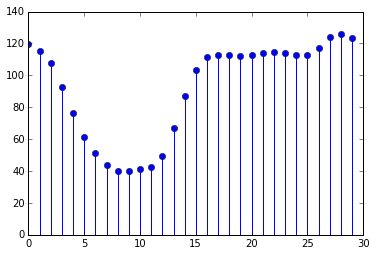

In [373]:
results = {}
broken = []
for i in range(1,21):
    try:
        results[i] = run_pipeline(i)
    except:
        broken.append(i)

75.6978442679


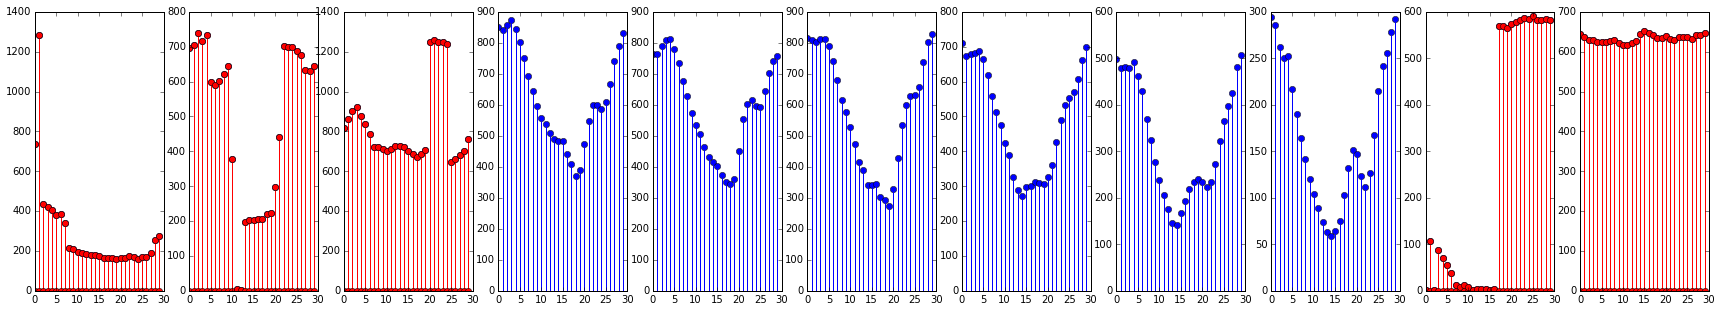

In [350]:
broken = []
for case in range(7,8):
    try:
        t,p,h = run_pipeline(case)
        a = t.sum(2).sum(2)
        num_times = t.shape[1]
        a_interp = linear_interpolate(a, num_times)
        fig = plt.figure(figsize=(30,5))
        for i, c in enumerate(a_interp):
            plt.subplot(1, len(a_interp), i+1)
            if curve_score(c) < 0.1:
                plt.stem(c)
            else:
                plt.stem(c, '-ro')
        #plt.savefig(str(case))
        #plt.close(fig)
    except:
        broken.append(case)

Correcting 2 with multiplier 1.000000
Correcting 1 with multiplier 1.000000
Correcting 0 with multiplier 1.000000
Correcting 9 with multiplier 0.631821
Correcting 10 with multiplier 0.458897


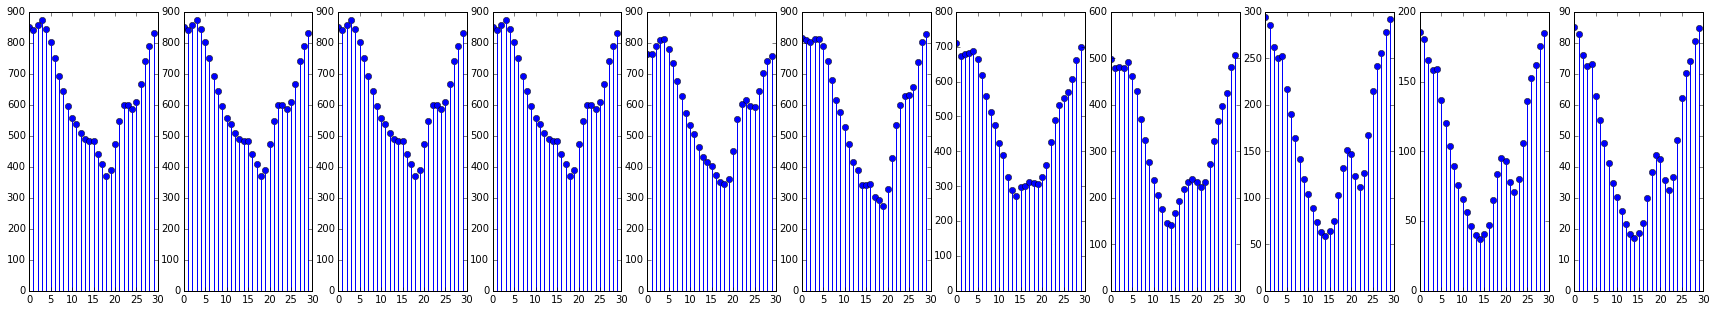

In [351]:
test = a_interp[::]
t = piecewise_interp(test)
plt.figure(figsize=(30,5))
for i, c in enumerate(t):
    plt.subplot(1, len(t), i+1)
    if curve_score(c) < 0.1:
        plt.stem(c)
    else:
        plt.stem(c, '-ro')

In [ ]:
areas = area_mults[:,None] * a_interp
# multiply each area by its height to get mm^3
volumes = heights[:,None] * areas
# return the sum of volumes over layers in ml
return np.sum(volumes, 0)/1000.

In [ ]:
area_mults

### Throw away bad ones, replace using piecewise linear model

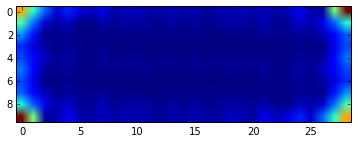

In [308]:
ft1 = np.fft.fft2(t)
plt.imshow(np.abs(ft1[1:,1:]))

In [126]:
from scipy import interpolate
x = np.array(range(13))
y = np.array(range(30))

f = interpolate.interp2d(x,y,a_interp.T, kind='cubic')

<Container object of 3 artists>

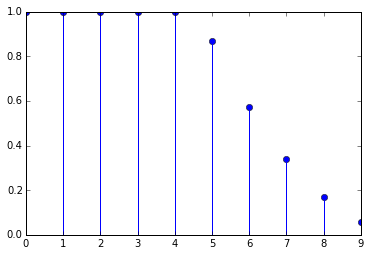

In [258]:
plt.stem([piecewise_linear(10, i)**2 for i in range(10)])

In [231]:
def get_good_curves(curves):
    return {i:c for i,c in enumerate(curves) if curve_score(c) < 0.1}

In [235]:
good = get_good_curves(a_interp)
locs = good.keys()
#curves = [g[1] for f in good]

In [274]:
area_matrix = np.array(a_interp)
area_matrix.shape

(11, 30)

In [301]:
ft = np.fft.fft2(area_matrix)

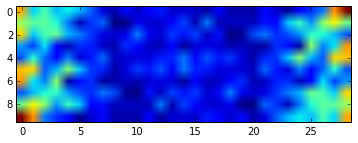

In [306]:
plt.imshow(np.abs(ft[1:,1:]))

In [311]:
new_area_matrix = ndimage.gaussian_filter(area_matrix,2.)

In [293]:
from scipy import signal
new_area_matrix = signal.medfilt2d(area_matrix, 7)

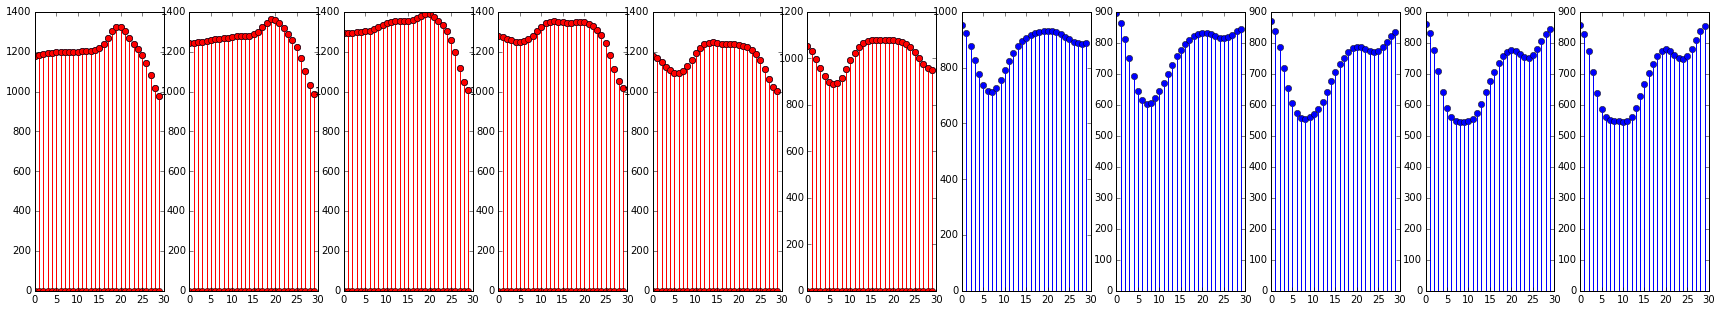

In [312]:
plt.figure(figsize=(30,5))
for i, c in enumerate(new_area_matrix):
    plt.subplot(1, len(t), i+1)
    if curve_score(c) < 0.1:
        plt.stem(c)
    else:
        plt.stem(c, '-ro')

# Attempting to correct bad points in a single curve

In [61]:
v = run_pipeline(1)

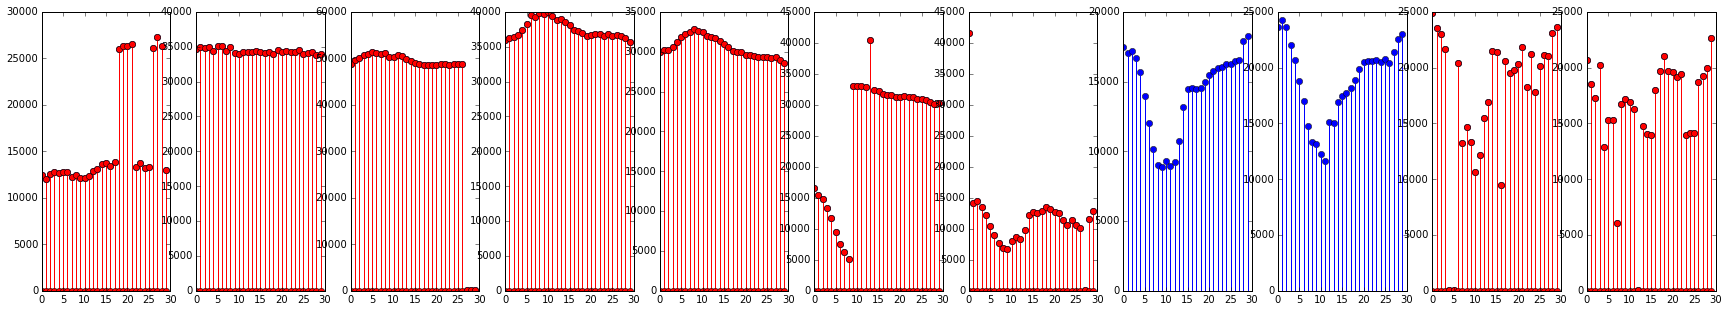

In [64]:
plt.figure(figsize=(30,5))
for i, c in enumerate(v):
    plt.subplot(1, len(v), i+1)
    if curve_score(c) < 0.1:
        plt.stem(c)
    else:
        plt.stem(c, '-ro')

### First try to find single outliers, either way too big, or way too small

In [231]:
from scipy import signal
curve = v[8].copy()
#new = signal.resample(curve[1:-3], 30)

<Container object of 3 artists>

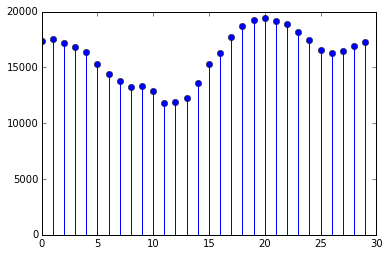

In [238]:
curve = v[10].copy()
ma = np.array([np.ma.average(curve[i-3:i]) for i in range(3,len(curve))])
ma = signal.resample(ma, 30)
plt.stem(fourier_interpolation(ma))

In [239]:
ft = scipy.fft(fourier_interpolation(ma))
np.linalg.norm(ft[0])/np.linalg.norm(ft[1:])

7.098290456643924

In [199]:
curve_score(fourier_interpolation(ma))

0.014074137358445872

In [80]:
np.abs(np.gradient(v[6]) - (np.gradient(v[6])).mean()) > (np.gradient(v[6])).std()

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False], dtype=bool)

In [85]:
curve_score(v[6])

0.71349359946355329

Found low anomaly


<Container object of 3 artists>

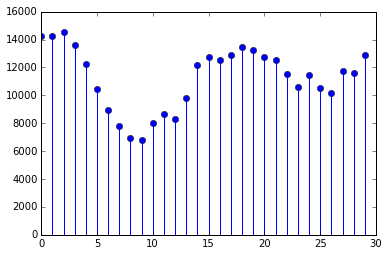

In [71]:
curve = v[6].copy()
for i in range(1, len(curve)-1):
    if curve[i] > 2*curve.mean():
        print 'Found high anomaly'
        curve[i] = curve.mean()
    if curve[i] < 0.3*curve.mean():
        curve[i] = curve.mean()
        print 'Found low anomaly'

#Check if the curve is still bad
if curve_score(curve) > 0.1:
    #See if the endpoints can fix it
    if curve_score(curve[1:-1]) < 0.15:
        if curve_score(curve[:-1]) > 0.1:
            curve[0] = curve[1]
        if curve_score(curve[1:]) > 0.1:
            curve[-1] = curve[-2]
plt.stem(curve)

In [72]:
curve_score(curve)

0.063760900219113889

<Container object of 3 artists>

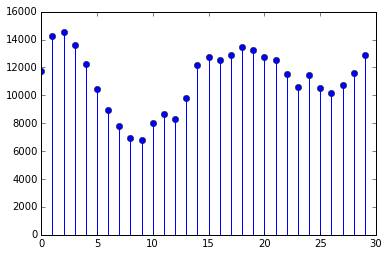

In [57]:
plt.stem(v[6])

In [36]:
test = v[6]

In [37]:
test > 2*test.mean()

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [42]:
curve_score(test[1:27])

0.14177068705520726